In [35]:
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from aves.features.geo import to_point_geodataframe
from cytoolz import valfilter, keymap
from gensim.utils import deaccent
from geopy.geocoders import Nominatim


In [16]:
elecciones = pd.read_csv(
    "../data/external/presidenciales_2021/Servel_20211121_PRESIDENCIALES_CHILE.csv",
    sep=";",
)
elecciones.head()

,eleccion_id,eleccion_nombre,region_id,region_nombre,provincia_id,provincia_nombre,comuna_id,comuna_nombre,circele_id,circele_nombre,...,codigo_colegio,nombre_colegio,sede_colegio,cs_id,cs,distrito_id,distrito,lista,pacto,partido_politico
0,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,CONVERGENCIA SOCIAL ...
1,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO REPUBLICANO DE CHILE ...
2,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,PARTIDO DEMOCRATA CRISTIANO ...
3,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,EVOLUCION POLITICA ...
4,4,Elección de Presidente 2021 ...,3001,DE TARAPACA ...,4011,IQUIQUE ...,2501,IQUIQUE ...,7007,IQUIQUE ...,...,101,LICEO DEPORTIVO ELENA DUVAUCHELLE CABEZON ...,ANIBAL PINTO 955 ...,5002,CIRCUNSCRIPCIÓN SENATORIAL 2 ...,6002,DISTRITO 2 ...,...,SIN PACTO ...,UNION PATRIOTICA ...


In [17]:
elecciones["location_name"] = (
    elecciones["local_nombre"].str.replace(r"LOCAL\s?:\s?\d+", "").str.strip()
)
elecciones["location_name"]


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0           LICEO LUIS CRUZ MARTINEZ
1           LICEO LUIS CRUZ MARTINEZ
2           LICEO LUIS CRUZ MARTINEZ
3           LICEO LUIS CRUZ MARTINEZ
4           LICEO LUIS CRUZ MARTINEZ
                     ...            
513024    LICEO TECNICO PUENTE ÑUBLE
513025    LICEO TECNICO PUENTE ÑUBLE
513026    LICEO TECNICO PUENTE ÑUBLE
513027    LICEO TECNICO PUENTE ÑUBLE
513028    LICEO TECNICO PUENTE ÑUBLE
Name: location_name, Length: 513029, dtype: object

In [18]:
elecciones["region_nombre"] = elecciones["region_nombre"].str.strip()


In [19]:
elecciones_region = elecciones[
    elecciones["region_nombre"] == "METROPOLITANA DE SANTIAGO"
].copy()


In [20]:
servel_locations = (
    pd.read_excel("../data/external/Locales_de_votacion.xlsx")
    .pipe(lambda x: x[x["Región"] == "METROPOLITANA DE SANTIAGO"])
    .assign(
        local=lambda x: x["Local de Votación"]
        .str.replace(r"LOCAL\s?:\s?\d+", "")
        .str.strip()
    )
    .drop_duplicates(subset=["Local de Votación"])
)
servel_locations


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Región Nº,Región,Junta Electoral,Comuna,Circunscripción Electoral,Local de Votación,Dirección,Mesas,local
1322,13.0,METROPOLITANA DE SANTIAGO,1RA DE SANTIAGO,SANTIAGO,EL CENTRO,ESCUELA DR LUIS CALVO MACKENNA,RICARDO CUMMING 735,21.0,ESCUELA DR LUIS CALVO MACKENNA
1323,13.0,METROPOLITANA DE SANTIAGO,1RA DE SANTIAGO,SANTIAGO,EL CENTRO,ESCUELA DR LUIS CALVO MACKENNA LOCAL: 2,RICARDO CUMMING 735,20.0,ESCUELA DR LUIS CALVO MACKENNA
1324,13.0,METROPOLITANA DE SANTIAGO,1RA DE SANTIAGO,SANTIAGO,EL CENTRO,ESCUELA LIBERTADORES DE CHILE,ROSAS 1741,32.0,ESCUELA LIBERTADORES DE CHILE
1325,13.0,METROPOLITANA DE SANTIAGO,1RA DE SANTIAGO,SANTIAGO,EL CENTRO,ESCUELA REPUBLICA DE ALEMANIA,LIBERTAD 1242,20.0,ESCUELA REPUBLICA DE ALEMANIA
1326,13.0,METROPOLITANA DE SANTIAGO,1RA DE SANTIAGO,SANTIAGO,EL CENTRO,ESCUELA REPUBLICA DE PANAMA,HUERFANOS 3151,26.0,ESCUELA REPUBLICA DE PANAMA
...,...,...,...,...,...,...,...,...,...
2027,13.0,METROPOLITANA DE SANTIAGO,VITACURA Y LO BARNECHEA,VITACURA,VITACURA,COLEGIO SAINT GEORGE'S LOCAL: 2,AMERICO VESPUCIO NORTE 5400,28.0,COLEGIO SAINT GEORGE'S
2028,13.0,METROPOLITANA DE SANTIAGO,VITACURA Y LO BARNECHEA,VITACURA,VITACURA,COLEGIO SAN PEDRO NOLASCO,AVDA. PDTE. KENNEDY 5850,24.0,COLEGIO SAN PEDRO NOLASCO
2029,13.0,METROPOLITANA DE SANTIAGO,VITACURA Y LO BARNECHEA,VITACURA,VITACURA,COLEGIO SANTA URSULA,NUEVA COSTANERA 4190,25.0,COLEGIO SANTA URSULA
2030,13.0,METROPOLITANA DE SANTIAGO,VITACURA Y LO BARNECHEA,VITACURA,VITACURA,COLEGIO TABANCURA,LAS HUALTATAS 10500,26.0,COLEGIO TABANCURA


In [21]:
locations = pd.Series(elecciones_region["location_name"].unique())
locations.shape


(779,)

In [32]:
location_addresses = servel_locations.set_index("local")["Dirección"].to_dict()
location_addresses = keymap(
    lambda x: x.replace("ESC.", "ESCUELA")
    .replace("ESC ", "ESCUELA ")
    .replace("EDUC.", "EDUCACIONAL")
    .replace("EDUC ", "EDUCACIONAL "),
    location_addresses,
)
location_addresses


{'ESCUELA DR LUIS CALVO MACKENNA': 'RICARDO CUMMING 735',
 'ESCUELA LIBERTADORES DE CHILE': 'ROSAS 1741',
 'ESCUELA REPUBLICA DE ALEMANIA': 'LIBERTAD 1242',
 'ESCUELA REPUBLICA DE PANAMA': 'HUERFANOS 3151',
 'ESCUELA SALVADOR SANFUENTES': 'CATEDRAL 3250',
 'INST.SUP.DE COMERCIO EDUARDO FREI M.': 'AMUNATEGUI 126',
 'LICEO DE APLICACION 21': 'RICARDO CUMMING 21',
 'LICEO DE APLICACION 29': 'RICARDO CUMMING 29',
 'LICEO INDUSTRIAL ELIODORO GARCIA ZEGERS': 'SANTO DOMINGO 1811',
 'LICEO ISAURA DINATOR DE GUZMAN': 'MATUCANA 73',
 'LICEO JAVIERA CARRERA': 'COMPAÑIA 1484',
 'LICEO MIGUEL DE CERVANTES Y SAAVEDRA ANEXO BASICA': 'AGUSTINAS 2492',
 'LICEO MIGUEL LUIS AMUNATEGUI': 'AGUSTINAS 2918',
 'ESCUELA REPUBLICA ORIENTAL DE URUGUAY': 'MANUEL ANTONIO TOCORNAL 533',
 'ESCUELA BENJAMIN VICUNA MACKENNA': 'VICUNA MACKENNA 635',
 'ESCUELA CADETE ARTURO PRAT CHACON': 'SAN IGNACIO 196',
 'ESCUELA FERNANDO ALESSANDRI RODRIGUEZ': 'LORD COCHRANE 850',
 'ESCUELA REPUBLICA DE COLOMBIA': 'BASCUÑAN GUERRERO

In [24]:
geolocator = Nominatim(user_agent="chilean_voting_location_analysis")

In [13]:
location_coords = {}


In [33]:
errors = 0

for loc in locations.values:
    if loc in location_coords:
        continue

    loc = loc.replace(" PARTICULAR", "").replace("NRO ", "N°")
    try:
        result = geolocator.geocode(
            f"{loc}, Región Metropolitana de Santiago, Chile"
        )

        if result is None and loc in location_addresses:
            result = geolocator.geocode(f"{loc}, Región Metropolitana de Santiago, Chile")

        location_coords[loc] = result
        print(loc, location_coords[loc])
    except Exception as e:
        print("error", e)
        errors += 1
        if errors >= 3:
            break
    finally:
        time.sleep(2)

location_coords


LICEO JAVIERA CARRERA Liceo Javiera Carrera, 1484, Compañía de Jesús, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8340347, Chile
INACAP SANTIAGO CENTRO INACAP Santiago Centro, Almirante Barroso, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 820000, Chile
LICEO N°2 MIGUEL LUIS AMUNATEGUI Liceo Nº2 Miguel Luis Amunátegui, 2918, Agustinas, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8350485, Chile
LICEO DE APLICACION RECTOR JORGE E SCHNE 29 Liceo de Aplicación Rector Jorge E. Schne, 21, Avenida Ricardo Cumming, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8370968, Chile
INSTITUTO SUPERIOR DE COMERCIO EDUARDO FREI MONTALVA Instituto Superior de Comercio Eduardo Frei Montalva, 126, Amunátegui, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8340665, Chile
ESCUELA BASICA LIBERTADORES DE CHILE Escuela Básica Libertadores De Chile, 1741, Rosas

{'LICEO JAVIERA CARRERA': Location(Liceo Javiera Carrera, 1484, Compañía de Jesús, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8340347, Chile, (-33.43936265000001, -70.65741899684026, 0.0)),
 'INACAP SANTIAGO CENTRO': Location(INACAP Santiago Centro, Almirante Barroso, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 820000, Chile, (-33.44352000000001, -70.66230852615486, 0.0)),
 'LICEO N°2 MIGUEL LUIS AMUNATEGUI': Location(Liceo Nº2 Miguel Luis Amunátegui, 2918, Agustinas, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8350485, Chile, (-33.44416055, -70.67582269910243, 0.0)),
 'LICEO DE APLICACION RECTOR JORGE E SCHNE 29': Location(Liceo de Aplicación Rector Jorge E. Schne, 21, Avenida Ricardo Cumming, Barrio Brasil, Santiago, Provincia de Santiago, Región Metropolitana de Santiago, 8370968, Chile, (-33.44648425, -70.66720683422005, 0.0)),
 'INSTITUTO SUPERIOR DE COMERCIO EDUARDO FREI MONTALVA':

In [36]:
len(valfilter(lambda x: x is not None, location_coords)), len(
    valfilter(lambda x: x is None, location_coords)
)


(424, 354)

/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

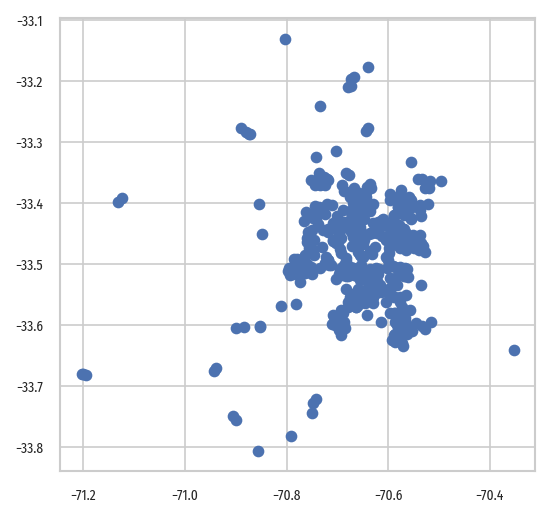

In [37]:
location_points = pd.DataFrame(
    [
        {"location": x[0], "x": x[1].longitude, "y": x[1].latitude}
        for x in valfilter(lambda x: x, location_coords).items()
    ]
).pipe(lambda x: to_point_geodataframe(x, "x", "y", drop=True))
location_points.plot()


In [38]:
grid = gpd.read_file(
    "../data/interim/scl-census-grid/scl-boundary-grid.geo.json"
).to_crs("epsg:4326")
grid


,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,s2_cellid,area_weight,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,10836461268177518592,208016.974474,"POLYGON ((-70.63231 -33.64724, -70.63250 -33.6..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,132,CORDILLERA,13201,PUENTE ALTO,0.497638,0.008573,10836461268177518592,1714.522585,"POLYGON ((-70.62203 -33.64363, -70.62295 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13401,SAN BERNARDO,0.852814,0.014857,10836461268177518592,232249.084050,"POLYGON ((-70.63033 -33.63657, -70.63035 -33.6..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,132,CORDILLERA,13202,PIRQUE,1.029066,0.043323,10836461268177518592,21167.070803,"POLYGON ((-70.63231 -33.64724, -70.63207 -33.6..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,10836461680494379008,317872.819618,"POLYGON ((-70.66886 -33.65788, -70.66712 -33.6..."
...,...,...,...,...,...,...,...,...,...,...,...
1219,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440343096852480,28138.530267,"POLYGON ((-70.64547 -33.45583, -70.64547 -33.4..."
1220,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440377456590848,8872.912504,"POLYGON ((-70.65737 -33.45776, -70.65737 -33.4..."
1221,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440721053974528,131569.094156,"POLYGON ((-70.63358 -33.45391, -70.63358 -33.4..."
1222,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,10836440961572143104,848556.024732,"POLYGON ((-70.64547 -33.43426, -70.64547 -33.4..."


/home/egraells/miniconda3/envs/chilean_voter_profiling/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

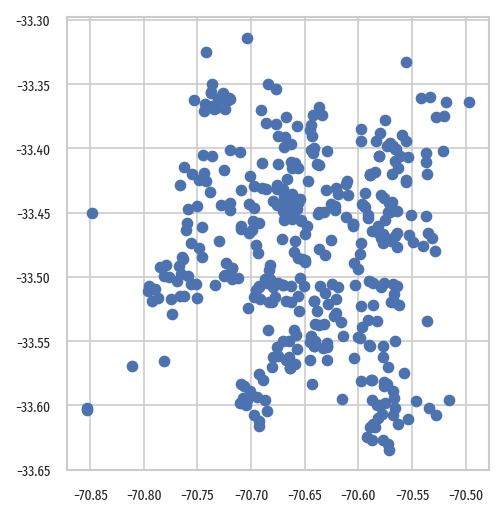

In [39]:
locations_in_grid = gpd.sjoin(location_points, grid, op="within", how="inner")
locations_in_grid.plot()


In [40]:
locations_in_grid[["location", "geometry", "s2_cellid"]].to_file(
    "../data/interim/scl-census-grid/scl-geolocated-voting-locations.geo.json",
    driver="GeoJSON",
)


In [41]:
locations_in_grid.shape

(393, 13)